In [ ]:
# --- CELDA 1: SETUP, ANÁLISIS Y DESCARGA DE 4 DATASETS ---

# 0. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 1. Instalación de dependencias
# Se fuerza la actualización de las dependencias en conflicto para evitar errores.
!pip install -U ultralytics roboflow opencv-python-headless certifi albumentations --quiet

# 2. Imports y configuración
import yaml
import logging
from pathlib import Path
from roboflow import Roboflow
import shutil
from collections import defaultdict

# --- Configuraciones Esenciales ---
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")
print("--- [CELDA 1] SETUP, ANÁLISIS Y DESCARGA DE 4 DATASETS (MODIFICADA) ---")
logging.info("--- [CELDA 1] SETUP, ANÁLISIS Y DESCARGA DE 4 DATASETS (MODIFICADA) ---")

# --- Definiciones Clave ---
# ADVERTENCIA: Por seguridad, es mejor usar los "Secrets" de Colab para las API keys.
# Para este caso, usamos la clave proporcionada directamente.
API_KEY = "tZR7XZhFvySrbVM3hfH4"

# Directorio local temporal en Colab para las descargas crudas
RAW_DIR = Path("/content/datasets_raw_temp")
RAW_DIR.mkdir(parents=True, exist_ok=True)
logging.info(f"Los datasets crudos se descargarán en: {RAW_DIR}")

# [MODIFICADO] Se cambió el nombre para evitar conflictos y ser más descriptivo.
FINAL_PROCESSED_DATASET_ON_DRIVE = Path("/content/drive/MyDrive/Coffee_Unified_Seg_v1")
FINAL_PROCESSED_DATASET_ON_DRIVE.mkdir(parents=True, exist_ok=True)
logging.info(f"El dataset procesado final se guardará en Drive en: {FINAL_PROCESSED_DATASET_ON_DRIVE}")

# Clases objetivo para el modelo final
UNIFIED_CLASS_LIST = ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
UNIFIED_CLASS_TO_IDX = {name: i for i, name in enumerate(UNIFIED_CLASS_LIST)}
EXCLUDE_CLASS_NAME = 'Enfermo' # Clase a ignorar durante la unificación

# --- Función para analizar y resumir un dataset YOLO ---
def analizar_dataset_yolo(dataset_path: Path):
    """
    Analiza un dataset en formato YOLO y devuelve un resumen que incluye
    conteo de etiquetas y conteo de imágenes únicas por clase.
    """
    data_yaml_path = dataset_path / "data.yaml"
    if not data_yaml_path.exists():
        print(f"  AVISO: No se encontró data.yaml en {dataset_path.name}")
        return

    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)

    class_names = data_yaml.get('names', [])
    if not class_names:
        print(f"  AVISO: No se encontraron nombres de clases en data.yaml para {dataset_path.name}")
        return

    stats = defaultdict(lambda: {'labels': 0, 'images': set()})
    total_images_with_labels = set()
    total_images_in_splits = 0

    for split in ['train', 'valid', 'test']:
        image_dir = dataset_path / split / "images"
        label_dir = dataset_path / split / "labels"

        if image_dir.exists():
            total_images_in_splits += len(list(image_dir.glob('*.[jp][pn]g'))) # Cuenta jpg, jpeg, png

        if label_dir.exists():
            for label_file in label_dir.glob('*.txt'):
                total_images_with_labels.add(label_file.stem)
                with open(label_file, 'r') as lf:
                    for line in lf:
                        try:
                            class_idx = int(line.split()[0])
                            if 0 <= class_idx < len(class_names):
                                class_name = class_names[class_idx]
                                stats[class_name]['labels'] += 1
                                stats[class_name]['images'].add(label_file.stem) # Usamos .stem para no incluir .txt
                        except (ValueError, IndexError):
                            continue

    print(f"  Resumen de '{dataset_path.name}':")
    print(f"  - Imágenes totales (en splits): {total_images_in_splits}")
    print(f"  - Imágenes con etiquetas: {len(total_images_with_labels)}")
    print(f"  - Estadísticas por clase:")
    for name, data in sorted(stats.items()):
        num_images_for_class = len(data['images'])
        print(f"      - {name}: {data['labels']} etiquetas en {num_images_for_class} imágenes")

# --- Descarga de Datasets Crudos ---
try:
    rf = Roboflow(api_key=API_KEY)
    logging.info("Roboflow SDK inicializado correctamente.")
except Exception as e_rf:
    logging.error(f"Error al inicializar Roboflow SDK: {e_rf}")
    raise RuntimeError("Fallo al inicializar Roboflow SDK") from e_rf

# [MODIFICADO] Se añadió el cuarto dataset a la lista de descarga.
projects_to_download = [
    ("wys-amyvz", "coffee-cherries-qpktr", 1),
    ("ciencia-cafeto", "coffee-fruit-maturity-befkg", 2),
    ("coffeeclassification-reduced", "coffeeclassification", 1),
    ("valentinaosorio", "coffe_fobv2", 5)
]
logging.info(f"Se intentará descargar/verificar {len(projects_to_download)} datasets.")
print(f"Se descargarán los siguientes {len(projects_to_download)} datasets:")
for ws, proj, ver in projects_to_download:
    print(f"  - Workspace: {ws}, Proyecto: {proj}, Versión: {ver}")

logging.info(f"--- Iniciando descarga/análisis de datasets crudos a {RAW_DIR} ---")
for workspace, project_name, version_number in projects_to_download:
    dest_folder_name = f"{project_name}_v{version_number}"
    dest_path = RAW_DIR / dest_folder_name

    if dest_path.exists() and any(dest_path.iterdir()):
        logging.info(f"✔️ Dataset '{dest_folder_name}' ya existe. Analizando...")
        print(f"\n✔️ Dataset '{dest_folder_name}' ya existe. Analizando:")
        analizar_dataset_yolo(dest_path)
        continue

    logging.info(f"⬇️ Descargando '{project_name}' v{version_number} en '{dest_path}'...")
    print(f"\n⬇️ Descargando '{project_name}' v{version_number}...")
    try:
        project_instance = rf.workspace(workspace).project(project_name)
        version_instance = project_instance.version(version_number)
        # Descargamos en formato yolov8-seg (aunque roboflow lo llame 'yolov8', el formato es compatible)
        version_instance.download("yolov8", location=str(dest_path))

        if dest_path.exists() and any(dest_path.iterdir()):
            logging.info(f"✅ Descarga completada. Analizando '{dest_folder_name}'...")
            print(f"✅ Descarga completada. Analizando:")
            analizar_dataset_yolo(dest_path)
        else:
            logging.error(f"❌ Error: La carpeta '{dest_folder_name}' está vacía después de la descarga.")
            print(f"❌ Error: La carpeta '{dest_folder_name}' está vacía después de la descarga.")

    except Exception as e_download:
        logging.error(f"❌ Error crítico al descargar {project_name}_v{version_number}: {e_download}")
        print(f"❌ Error crítico al descargar {project_name}_v{version_number}: {e_download}")


logging.info(f"--- Proceso de descarga y análisis completado. ---")
print("\n--- FIN DE CELDA 1 ---")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━


Extracting Dataset Version Zip to /content/datasets_raw_temp/coffee-cherries-qpktr_v1 in yolov8:: 100%|██████████| 4128/4128 [00:01<00:00, 2776.41it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Descarga completada. Analizando:
  Resumen de 'coffee-cherries-qpktr_v1':
  - Imágenes totales (en splits): 2058
  - Imágenes con etiquetas: 2058
  - Estadísticas por clase:
      - 0: 711 etiquetas en 260 imágenes
      - 1: 505 etiquetas en 191 imágenes
      - 2: 3214 etiquetas en 563 imágenes
      - 3: 2111 etiquetas en 471 imágenes
      - 4: 19476 etiquetas en 1786 imágenes

⬇️ Descargando 'coffee-fruit-maturity-befkg' v2...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets_raw_temp/coffee-fruit-maturity-befkg_v2 in yolov8:: 100%|██████████| 4520/4520 [00:00<00:00, 4777.49it/s]


✅ Descarga completada. Analizando:
  Resumen de 'coffee-fruit-maturity-befkg_v2':
  - Imágenes totales (en splits): 2254
  - Imágenes con etiquetas: 2254
  - Estadísticas por clase:
      - dry: 1246 etiquetas en 306 imágenes
      - overripe: 600 etiquetas en 220 imágenes
      - ripe: 3400 etiquetas en 576 imágenes
      - semi_ripe: 2019 etiquetas en 462 imágenes
      - unripe: 25124 etiquetas en 1966 imágenes

⬇️ Descargando 'coffeeclassification' v1...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets_raw_temp/coffeeclassification_v1 in yolov8:: 100%|██████████| 312/312 [00:00<00:00, 3361.54it/s]

✅ Descarga completada. Analizando:
  Resumen de 'coffeeclassification_v1':
  - Imágenes totales (en splits): 150
  - Imágenes con etiquetas: 150
  - Estadísticas por clase:
      - diseased: 85 etiquetas en 13 imágenes
      - dry: 316 etiquetas en 60 imágenes
      - overripe: 224 etiquetas en 65 imágenes
      - ripe: 526 etiquetas en 103 imágenes
      - semi_ripe: 433 etiquetas en 89 imágenes
      - unripe: 901 etiquetas en 107 imágenes

⬇️ Descargando 'coffe_fobv2' v5...
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets_raw_temp/coffe_fobv2_v5 in yolov8:: 100%|██████████| 4224/4224 [00:01<00:00, 2266.00it/s]


✅ Descarga completada. Analizando:
  Resumen de 'coffe_fobv2_v5':
  - Imágenes totales (en splits): 2109
  - Imágenes con etiquetas: 2109
  - Estadísticas por clase:
      - overripe: 8635 etiquetas en 1598 imágenes
      - ripe: 12629 etiquetas en 1841 imágenes
      - semi_ripe: 9241 etiquetas en 1732 imágenes
      - unripe: 9243 etiquetas en 1652 imágenes

--- FIN DE CELDA 1 ---


In [ ]:
# --- CELDA 2: ESTANDARIZACIÓN DE CLASES Y ANÁLISIS POST-PROCESO ---

import yaml
import logging
from pathlib import Path
import shutil
from collections import defaultdict

print("--- [CELDA 2] INICIANDO ESTANDARIZACIÓN DE CLASES ---")
logging.info("--- [CELDA 2] INICIANDO ESTANDARIZACIÓN DE CLASES ---")

# --- Re-declaración de Constantes (para que la celda sea autocontenida) ---
RAW_DIR = Path("/content/datasets_raw_temp")
UNIFIED_CLASS_LIST = ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
UNIFIED_CLASS_TO_IDX = {name: i for i, name in enumerate(UNIFIED_CLASS_LIST)}

# --- MAPEO DE CLASES ---
# Las claves son los nombres de las carpetas de los datasets descargados.
LABEL_MAPS = {
    "coffee-cherries-qpktr_v1": {
        '4': 'Inmaduro', '3': 'Pinton', '2': 'Maduro', '1': 'Sobremaduro', '0': 'Seco'
    },
    "coffee-fruit-maturity-befkg_v2": {
        'unripe': 'Inmaduro', 'semi_ripe': 'Pinton', 'ripe': 'Maduro', 'overripe': 'Sobremaduro', 'dry': 'Seco'
    },
    "coffeeclassification_v1": {
        'unripe': 'Inmaduro', 'semi_ripe': 'Pinton', 'ripe': 'Maduro', 'overripe': 'Sobremaduro', 'dry': 'Seco',
        'diseased': None  # None significa que esta clase será ignorada y eliminada.
    },
    "coffe_fobv2_v5": {
        'overripe': 'Sobremaduro' # Solo interesa esta clase, el resto se ignorará.
    }
}

# --- Función para analizar el dataset CON LAS CLASES YA ESTANDARIZADAS ---
def analizar_dataset_estandarizado(dataset_path: Path):
    """
    Analiza un dataset cuyas etiquetas YA HAN SIDO estandarizadas.
    Usa la lista de clases global UNIFIED_CLASS_LIST en lugar del data.yaml local.
    """
    print(f"  Análisis Estandarizado de '{dataset_path.name}':")

    stats = defaultdict(lambda: {'labels': 0, 'images': set()})
    total_images_with_labels = set()

    for split in ['train', 'valid', 'test']:
        label_dir = dataset_path / split / "labels"
        if not label_dir.exists():
            continue

        for label_file in label_dir.glob('*.txt'):
            image_has_valid_label = False
            with open(label_file, 'r') as lf:
                for line in lf:
                    try:
                        # El class_idx ahora corresponde a UNIFIED_CLASS_LIST
                        class_idx = int(line.split()[0])
                        if 0 <= class_idx < len(UNIFIED_CLASS_LIST):
                            class_name = UNIFIED_CLASS_LIST[class_idx]
                            stats[class_name]['labels'] += 1
                            stats[class_name]['images'].add(label_file.stem)
                            image_has_valid_label = True
                    except (ValueError, IndexError):
                        continue
            if image_has_valid_label:
                total_images_with_labels.add(label_file.stem)

    print(f"  - Imágenes con etiquetas válidas: {len(total_images_with_labels)}")
    print(f"  - Estadísticas por clase (estandarizada):")
    if not stats:
        print("      - No se encontraron etiquetas para las clases deseadas en este dataset.")
        return

    for name, data in sorted(stats.items(), key=lambda item: UNIFIED_CLASS_LIST.index(item[0])):
        num_images_for_class = len(data['images'])
        print(f"      - {name}: {data['labels']} etiquetas en {num_images_for_class} imágenes")


# --- Función principal para reescribir las etiquetas de un dataset ---
def estandarizar_labels_de_dataset(dataset_path: Path, label_map: dict):
    """
    Modifica los archivos de etiquetas de un dataset para usar los índices de clase unificados.
    """
    print(f"\n🔄 Estandarizando dataset: '{dataset_path.name}'...")
    data_yaml_path = dataset_path / "data.yaml"
    if not data_yaml_path.exists():
        logging.warning(f"No se encontró data.yaml en {dataset_path.name}, se omitirá.")
        return

    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)

    original_class_names = data_yaml.get('names', [])

    # Mapeo: índice_original -> índice_nuevo_unificado
    idx_map = {}
    for original_idx, original_name in enumerate(original_class_names):
        unified_name = label_map.get(original_name)
        if unified_name: # Si la clase está en nuestro mapa y no es None
            new_idx = UNIFIED_CLASS_TO_IDX.get(unified_name)
            idx_map[original_idx] = new_idx

    logging.info(f"Mapeo para {dataset_path.name}: {idx_map}")

    # Procesar cada split (train/valid/test)
    for split in ['train', 'valid', 'test']:
        label_dir = dataset_path / split / "labels"
        if not label_dir.exists():
            continue

        # Directorio temporal para las nuevas etiquetas
        new_label_dir = dataset_path / f"labels_standardized_{split}"
        new_label_dir.mkdir(exist_ok=True)

        archivos_modificados = 0
        for label_file in label_dir.glob('*.txt'):
            new_lines = []
            with open(label_file, 'r') as lf:
                for line in lf:
                    parts = line.strip().split()
                    if not parts: continue

                    original_idx = int(parts[0])
                    if original_idx in idx_map:
                        new_idx = idx_map[original_idx]
                        new_line = f"{new_idx} {' '.join(parts[1:])}"
                        new_lines.append(new_line)

            # Si el archivo tiene contenido válido después de la conversión, se guarda
            if new_lines:
                with open(new_label_dir / label_file.name, 'w') as lf_new:
                    lf_new.write("\n".join(new_lines))
                archivos_modificados += 1

        # Reemplazar la carpeta de etiquetas original por la estandarizada
        shutil.rmtree(label_dir)
        shutil.move(str(new_label_dir), str(label_dir))
        logging.info(f"Split '{split}' en {dataset_path.name}: {archivos_modificados} archivos de etiquetas procesados y actualizados.")

    print(f"✅ Estandarización completa para '{dataset_path.name}'.")


# --- Bucle Principal de Ejecución ---
try:
    # Iteramos sobre los datasets que definimos para descargar
    for dataset_folder_name, class_map in LABEL_MAPS.items():
        dataset_path = RAW_DIR / dataset_folder_name
        if dataset_path.exists():
            # 1. Modificar los archivos de etiquetas
            estandarizar_labels_de_dataset(dataset_path, class_map)

            # 2. Analizar los resultados para verificar
            analizar_dataset_estandarizado(dataset_path)
        else:
            logging.warning(f"No se encontró la carpeta del dataset: {dataset_folder_name}")

except Exception as e:
    logging.error(f"Ocurrió un error durante la estandarización: {e}")
    print(f"❌ Ocurrió un error: {e}")

print("\n--- FIN DE CELDA 2 ---")

--- [CELDA 2] INICIANDO ESTANDARIZACIÓN DE CLASES ---

🔄 Estandarizando dataset: 'coffee-cherries-qpktr_v1'...
✅ Estandarización completa para 'coffee-cherries-qpktr_v1'.
  Análisis Estandarizado de 'coffee-cherries-qpktr_v1':
  - Imágenes con etiquetas válidas: 2058
  - Estadísticas por clase (estandarizada):
      - Inmaduro: 19476 etiquetas en 1786 imágenes
      - Pinton: 2111 etiquetas en 471 imágenes
      - Maduro: 3214 etiquetas en 563 imágenes
      - Sobremaduro: 505 etiquetas en 191 imágenes
      - Seco: 711 etiquetas en 260 imágenes

🔄 Estandarizando dataset: 'coffee-fruit-maturity-befkg_v2'...
✅ Estandarización completa para 'coffee-fruit-maturity-befkg_v2'.
  Análisis Estandarizado de 'coffee-fruit-maturity-befkg_v2':
  - Imágenes con etiquetas válidas: 2254
  - Estadísticas por clase (estandarizada):
      - Inmaduro: 25124 etiquetas en 1966 imágenes
      - Pinton: 2019 etiquetas en 462 imágenes
      - Maduro: 3400 etiquetas en 576 imágenes
      - Sobremaduro: 600 et

--- [CELDA 3] INICIANDO UNIFICACIÓN Y BALANCEO INTELIGENTE ---
✅ Directorio de destino 'Coffee_Unified_Seg_v1' preparado.

🔄 Construyendo manifiesto de datos de los 4 datasets...


Procesando datasets:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Manifiesto construido con 6060 imágenes únicas y válidas.

⚖️ Iniciando algoritmo de selección. Objetivo: ~2273 etiquetas por clase.
 Fase 1: Seleccionando todas las imágenes con la clase 'Seco'...
 ✅ Fase 1 completa. Imágenes seleccionadas: 626. Estado actual de etiquetas: {'Inmaduro': 5214, 'Seco': 2273, 'Maduro': 759, 'Pinton': 1387, 'Sobremaduro': 502}

 Fase 2: Llenando el resto de clases de forma balanceada...


Balanceando clases:   0%|          | 0/4 [00:00<?, ?it/s]

 ✅ Fase 2 completa. Total de imágenes seleccionadas: 868.

🚚 Copiando 868 imágenes y etiquetas a Google Drive...


Copiando archivos:   0%|          | 0/868 [00:00<?, ?it/s]

✅ Archivos copiados exitosamente.

📝 Creando archivo 'data.yaml' final...
✅ 'data.yaml' creado.

📊 Generando gráfica del balanceo final de etiquetas...


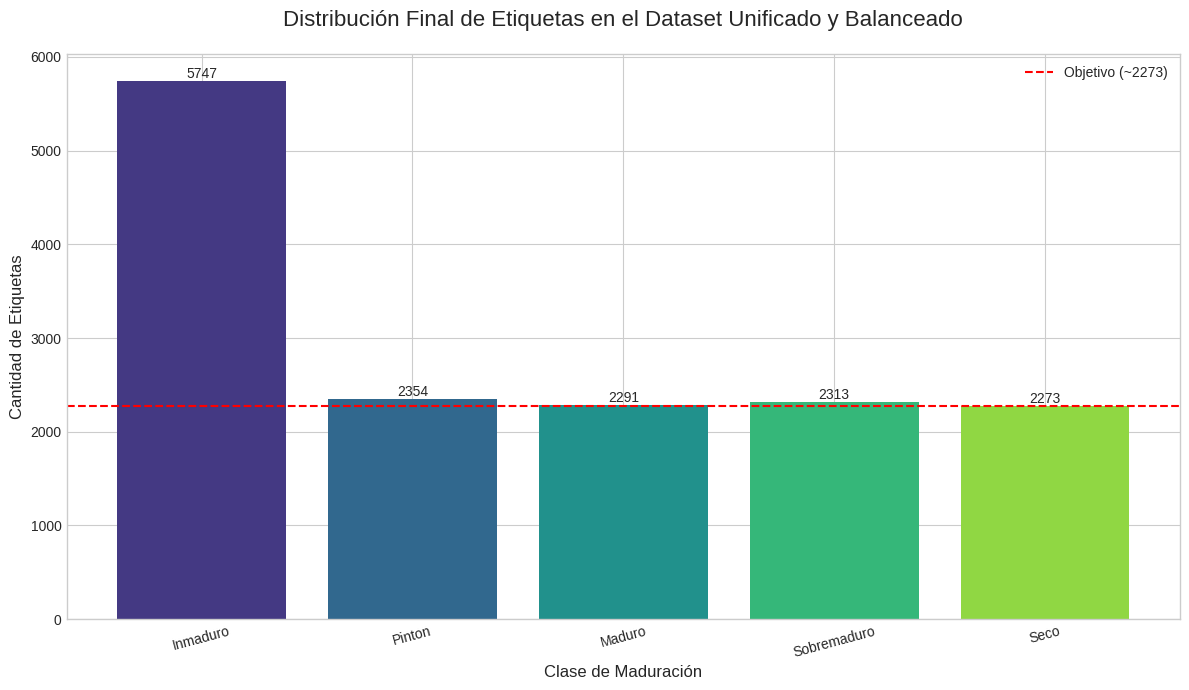


--- FIN DE CELDA 3: PROCESO COMPLETADO ---


In [ ]:
# --- CELDA 3: UNIFICACIÓN, BALANCEO INTELIGENTE Y VISUALIZACIÓN ---

import yaml
import logging
import shutil
import random
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm
import hashlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- [CELDA 3] INICIANDO UNIFICACIÓN Y BALANCEO INTELIGENTE ---")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")

# --- Re-declaración de Constantes ---
RAW_DIR = Path("/content/datasets_raw_temp")
FINAL_PROCESSED_DATASET_ON_DRIVE = Path("/content/drive/MyDrive/Coffee_Unified_Seg_v1")
UNIFIED_CLASS_LIST = ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
UNIFIED_CLASS_TO_IDX = {name: i for i, name in enumerate(UNIFIED_CLASS_LIST)}

# --- 1. PREPARACIÓN DEL DIRECTORIO FINAL ---
logging.info(f"Limpiando y preparando el directorio de destino: {FINAL_PROCESSED_DATASET_ON_DRIVE}")
if FINAL_PROCESSED_DATASET_ON_DRIVE.exists():
    shutil.rmtree(FINAL_PROCESSED_DATASET_ON_DRIVE)
FINAL_PROCESSED_DATASET_ON_DRIVE.mkdir(parents=True)

# Crear subdirectorios train/valid/test para imágenes y etiquetas
SPLITS = ['train', 'valid', 'test']
for split in SPLITS:
    (FINAL_PROCESSED_DATASET_ON_DRIVE / split / 'images').mkdir(parents=True)
    (FINAL_PROCESSED_DATASET_ON_DRIVE / split / 'labels').mkdir(parents=True)
print(f"✅ Directorio de destino '{FINAL_PROCESSED_DATASET_ON_DRIVE.name}' preparado.")

# --- 2. CONSTRUCCIÓN DEL MANIFIESTO DE DATOS ---
# Esta estructura contendrá información de cada imagen de los datasets.

def get_image_hash(image_path):
    """Calcula un hash SHA256 para una imagen."""
    hasher = hashlib.sha256()
    with Image.open(image_path) as img:
        img_byte_arr = img.tobytes()
        hasher.update(img_byte_arr)
    return hasher.hexdigest()

manifest = []
seen_hashes = set() # Para la deduplicación del dataset 4
dataset_priority_map = {
    "coffee-cherries-qpktr_v1": 1,
    "coffee-fruit-maturity-befkg_v2": 2,
    "coffeeclassification_v1": 3,
    "coffe_fobv2_v5": 4
}

print("\n🔄 Construyendo manifiesto de datos de los 4 datasets...")
for dataset_name, priority in tqdm(dataset_priority_map.items(), desc="Procesando datasets"):
    dataset_path = RAW_DIR / dataset_name
    for split in SPLITS:
        image_dir = dataset_path / split / 'images'
        label_dir = dataset_path / split / 'labels'
        if not image_dir.exists() or not label_dir.exists():
            continue

        for image_file in image_dir.glob('*.[jp][pn]g'):
            label_file = label_dir / f"{image_file.stem}.txt"
            if not label_file.exists():
                continue

            # Regla de deduplicación para el dataset 4
            if priority == 4:
                img_hash = get_image_hash(image_file)
                if img_hash in seen_hashes:
                    continue # Omitir imagen duplicada
                seen_hashes.add(img_hash)

            # Contar etiquetas por clase en esta imagen
            label_counts = defaultdict(int)
            with open(label_file, 'r') as f:
                for line in f:
                    class_idx = int(line.split()[0])
                    class_name = UNIFIED_CLASS_LIST[class_idx]
                    label_counts[class_name] += 1

            if not label_counts: # No añadir imágenes que quedaron sin etiquetas válidas
                continue

            manifest.append({
                'id': f"{dataset_name}_{image_file.name}",
                'source_dataset': dataset_name,
                'priority': priority,
                'split': split,
                'image_path': image_file,
                'label_path': label_file,
                'label_counts': label_counts
            })
print(f"✅ Manifiesto construido con {len(manifest)} imágenes únicas y válidas.")


# --- 3. ALGORITMO DE SELECCIÓN BALANCEADA ---

TARGET_COUNT = 2273 # objetivo para cada clase
final_label_counts = defaultdict(int)
selected_images = {} # Usamos dict para evitar duplicados por ID

print(f"\n⚖️ Iniciando algoritmo de selección. Objetivo: ~{TARGET_COUNT} etiquetas por clase.")

# --- Fase 1: Selección obligatoria de la clase minoritaria 'Seco' ---
print(" Fase 1: Seleccionando todas las imágenes con la clase 'Seco'...")
images_with_seco = [img for img in manifest if img['label_counts']['Seco'] > 0]
for img_data in images_with_seco:
    if img_data['id'] not in selected_images:
        selected_images[img_data['id']] = img_data
        for class_name, count in img_data['label_counts'].items():
            final_label_counts[class_name] += count
print(f" ✅ Fase 1 completa. Imágenes seleccionadas: {len(selected_images)}. Estado actual de etiquetas: {dict(final_label_counts)}")

# --- Fase 2: Llenado de las clases restantes respetando prioridades ---
print("\n Fase 2: Llenando el resto de clases de forma balanceada...")

# Ordenar el manifiesto restante por prioridad de dataset
remaining_manifest = [img for img in manifest if img['id'] not in selected_images]
remaining_manifest.sort(key=lambda x: x['priority'])

# Clases a llenar (excluyendo 'Seco', que ya es la base)
classes_to_fill = ['Sobremaduro', 'Pinton', 'Maduro', 'Inmaduro']

for class_to_fill in tqdm(classes_to_fill, desc="Balanceando clases"):

    # Filtrar candidatos que contienen la clase a llenar
    candidates = [img for img in remaining_manifest if img['id'] not in selected_images and img['label_counts'][class_to_fill] > 0]

    # Ordenar candidatos para maximizar el aporte a la clase objetivo
    candidates.sort(key=lambda x: x['label_counts'][class_to_fill], reverse=True)

    for candidate in candidates:
        if final_label_counts[class_to_fill] >= TARGET_COUNT:
            break # Objetivo para esta clase alcanzado

        if candidate['id'] not in selected_images:
            selected_images[candidate['id']] = candidate
            for class_name, count in candidate['label_counts'].items():
                final_label_counts[class_name] += count

print(f" ✅ Fase 2 completa. Total de imágenes seleccionadas: {len(selected_images)}.")


# --- 4. COPIAR ARCHIVOS SELECCIONADOS AL DESTINO FINAL ---
print(f"\n🚚 Copiando {len(selected_images)} imágenes y etiquetas a Google Drive...")
for img_id, img_data in tqdm(selected_images.items(), desc="Copiando archivos"):
    dest_split = img_data['split']

    # Copiar imagen
    source_image_path = img_data['image_path']
    dest_image_path = FINAL_PROCESSED_DATASET_ON_DRIVE / dest_split / 'images' / img_id
    shutil.copy(source_image_path, dest_image_path)

    # Copiar etiqueta
    source_label_path = img_data['label_path']
    dest_label_path = FINAL_PROCESSED_DATASET_ON_DRIVE / dest_split / 'labels' / f"{dest_image_path.stem}.txt"
    shutil.copy(source_label_path, dest_label_path)

print("✅ Archivos copiados exitosamente.")

# --- 5. CREAR EL ARCHIVO data.yaml FINAL ---
print("\n📝 Creando archivo 'data.yaml' final...")
final_yaml_data = {
    'train': f"../{FINAL_PROCESSED_DATASET_ON_DRIVE.name}/train/images",
    'val': f"../{FINAL_PROCESSED_DATASET_ON_DRIVE.name}/valid/images",
    'test': f"../{FINAL_PROCESSED_DATASET_ON_DRIVE.name}/test/images",
    'nc': len(UNIFIED_CLASS_LIST),
    'names': UNIFIED_CLASS_LIST
}
with open(FINAL_PROCESSED_DATASET_ON_DRIVE / 'data.yaml', 'w') as f:
    yaml.dump(final_yaml_data, f, sort_keys=False)
print("✅ 'data.yaml' creado.")

# --- 6. VISUALIZACIÓN DEL BALANCEO FINAL ---
print("\n📊 Generando gráfica del balanceo final de etiquetas...")
final_counts_list = [final_label_counts[c] for c in UNIFIED_CLASS_LIST]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.bar(UNIFIED_CLASS_LIST, final_counts_list, color=sns.color_palette("viridis", len(UNIFIED_CLASS_LIST)))
ax.axhline(y=TARGET_COUNT, color='r', linestyle='--', label=f'Objetivo (~{TARGET_COUNT})')

ax.set_title('Distribución Final de Etiquetas en el Dataset Unificado y Balanceado', fontsize=16, pad=20)
ax.set_ylabel('Cantidad de Etiquetas', fontsize=12)
ax.set_xlabel('Clase de Maduración', fontsize=12)
ax.legend()

# Añadir etiquetas de valor sobre las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print("\n--- FIN DE CELDA 3: PROCESO COMPLETADO ---")